In [18]:
%%capture
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt

In [19]:
names = open("names.txt").read().split()
vocab = sorted(set(''.join(names) + "."))
stoi = {s:i for i,s in enumerate(vocab, start=1)}
itos = {i:s for s,i in stoi.items()}

In [20]:
def encode(name: str) -> list[int]:
  return [stoi[i] for i in list(name)]

def decode(indices: list[int]) -> str:
  return ''.join(itos[i] for i in indices)

In [21]:
X = []
Y = []

for name in names:
  name = "." + name + "."
  name = encode(name)
  X.append(name[:-1])
  Y.append(name[1:])

In [22]:
total_len = len(X)
train_size = 0.8

Xtr, Xts = X[:int(total_len * train_size)], X[int(total_len * train_size):]
Ytr, Yts = Y[:int(total_len * train_size)], Y[int(total_len * train_size):]

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader

class RNNDataset(Dataset):
  def __init__(self, X, Y):
    super().__init__()
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return torch.tensor(self.X[idx]), torch.tensor(self.Y[idx])

Dtr = RNNDataset(Xtr, Ytr)
Dts = RNNDataset(Xts, Yts)

In [24]:
def collate(batch):
  X, Y = zip(*batch)

  padded_idxs = torch.nn.utils.rnn.pad_sequence(X, batch_first=True)
  padded_labels = torch.nn.utils.rnn.pad_sequence(Y, batch_first=True)

  return padded_idxs, padded_labels

DLtr = DataLoader(Dtr, batch_size=4, shuffle=True, collate_fn=collate)
DLts = DataLoader(Dts, batch_size=4, shuffle=False, collate_fn=collate)

In [25]:
import torch.nn as nn
import types

config  = types.SimpleNamespace(**{
    "vocab_size": len(vocab) + 1,
    "n_emb": 16,
    "hidden": 32,
})

class CustomRNN(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.emb = nn.Embedding(config.vocab_size, config.n_emb)
    self.rnn = nn.RNN(config.n_emb, config.hidden)
    self.fc = nn.Linear(config.hidden, config.vocab_size)

  def forward(self, x):
    x = self.emb(x)
    out, h = self.rnn(x)
    x = self.fc(out)
    return x

model = CustomRNN(config)

In [26]:
import torch.nn.functional as F
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossi = []

for epoch in range(10):
  for x, y in DLtr:
    logits = model(x)
    B, T, C = logits.shape
    logits = logits.view(B * T, C)
    y = y.view(B * T)
    loss = F.cross_entropy(logits, y, ignore_index=0)
    lossi.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  avg_loss = sum(lossi)/len(lossi)
  print(f"Epoch: {epoch+1} -> Loss: {avg_loss:.4f}")

Epoch: 1 -> Loss: 2.4567
Epoch: 2 -> Loss: 2.4264
Epoch: 3 -> Loss: 2.4144
Epoch: 4 -> Loss: 2.4074
Epoch: 5 -> Loss: 2.4028
Epoch: 6 -> Loss: 2.3996
Epoch: 7 -> Loss: 2.3968
Epoch: 8 -> Loss: 2.3948
Epoch: 9 -> Loss: 2.3931
Epoch: 10 -> Loss: 2.3917


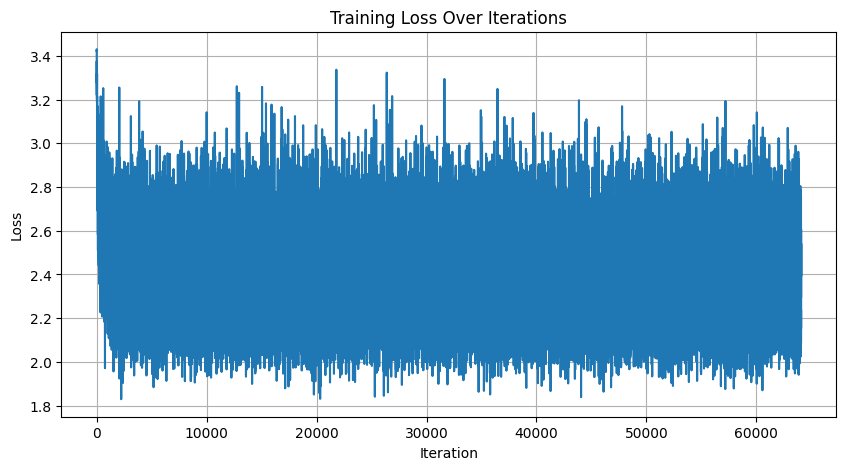

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(torch.tensor(lossi))
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()